In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=7
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'FTS.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [4]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2016-12-31,2094,-684,1410,225,269,1127,372,2166,12364,...,47904,0,1155,327,3944,20817,33307,475,-680,402
1,2017-03-31,2274,-754,1520,337,298,1133,320,2152,12261,...,48049,0,545,1166,4156,20277,32838,541,-709,421
2,2017-06-30,2015,-524,1491,312,231,1106,355,2063,11991,...,47581,0,568,1254,4080,19926,32267,649,-719,421
3,2017-09-30,1901,-478,1423,321,252,1047,382,2075,11588,...,46845,0,668,1062,3962,19495,31721,800,-706,421
4,2017-12-31,2111,-605,1506,323,327,1131,367,2207,11644,...,47822,0,209,752,3504,20691,32819,766,-890,421


## Calculate date when quaterly reports could be available

In [5]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [6]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
24,2022-12-31,2023-02-11,488,3168,-1268,1900,420,209,1759,661,...,1548,64252,0,253,2481,6617,25931,43222,869,-1114
25,2023-03-31,2023-04-21,490,3319,-1312,2007,484,576,1876,569,...,1511,64630,0,361,2362,6150,26466,43363,915,-954
26,2023-06-30,2023-07-21,490,2594,-787,1807,346,690,1580,534,...,1492,64081,0,80,2284,5414,26808,42702,944,-982
27,2023-09-30,2023-10-21,490,2719,-773,1946,445,765,1648,588,...,1515,66285,0,78,2774,6368,27170,44593,940,-983
28,2023-12-31,2024-02-11,490,2885,899,1986,435,625,1627,566,...,1510,65920,0,119,2296,5964,27235,42588,746,-1250


## Pull historical average USD national currency rates and add to the dataframe

In [7]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,488,3168,-1268,1900,420,209,1759,661,...,64252,0,253,2481,6617,25931,43222,869,-1114,1.357405
25,2023-03-31,2023-04-21,490,3319,-1312,2007,484,576,1876,569,...,64630,0,361,2362,6150,26466,43363,915,-954,1.352063
26,2023-06-30,2023-07-21,490,2594,-787,1807,346,690,1580,534,...,64081,0,80,2284,5414,26808,42702,944,-982,1.343352
27,2023-09-30,2023-10-21,490,2719,-773,1946,445,765,1648,588,...,66285,0,78,2774,6368,27170,44593,940,-983,1.341033
28,2023-12-31,2024-02-11,490,2885,899,1986,435,625,1627,566,...,65920,0,119,2296,5964,27235,42588,746,-1250,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [8]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,488,3168,-1268,1900,420,209,1759,661,...,64252,0,253,2481,6617,25931,43222,869,-1114,1.357405
25,2023-03-31,2023-04-21,490,3319,-1312,2007,484,576,1876,569,...,64630,0,361,2362,6150,26466,43363,915,-954,1.352063
26,2023-06-30,2023-07-21,490,2594,-787,1807,346,690,1580,534,...,64081,0,80,2284,5414,26808,42702,944,-982,1.343352
27,2023-09-30,2023-10-21,490,2719,-773,1946,445,765,1648,588,...,66285,0,78,2774,6368,27170,44593,940,-983,1.341033
28,2023-12-31,2024-02-11,490,2885,899,1986,435,625,1627,566,...,65920,0,119,2296,5964,27235,42588,746,-1250,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [9]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [10]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [11]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [12]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2017-02-13,32.848911,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,269.0,...,0.304714,0.695286,7.432121,inf,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657
1,2017-02-20,32.798912,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,269.0,...,0.304714,0.695286,7.432121,inf,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657
2,2017-02-27,32.522583,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,269.0,...,0.304714,0.695286,7.432121,inf,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657
3,2017-03-06,32.630058,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,269.0,...,0.304714,0.695286,7.432121,inf,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657
4,2017-03-13,32.883358,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,269.0,...,0.304714,0.695286,7.432121,inf,31.137546,7.354839,0.673352,0.10745,0.018788,0.061657


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [13]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2017-02-13,32.848911,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,269.0,...,7.354839,0.673352,0.10745,0.018788,0.061657,14.672514,0.904656,1.576559,5.520924,2.858282
1,2017-02-20,32.798912,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,269.0,...,7.354839,0.673352,0.10745,0.018788,0.061657,14.650181,0.903279,1.574160,5.518525,2.853931
2,2017-02-27,32.522583,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,269.0,...,7.354839,0.673352,0.10745,0.018788,0.061657,14.526754,0.895669,1.560898,5.505262,2.829887
3,2017-03-06,32.630058,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,269.0,...,7.354839,0.673352,0.10745,0.018788,0.061657,14.574759,0.898629,1.566056,5.510421,2.839239
4,2017-03-13,32.883358,2016-12-31,2094.0,2.238806,36.310945,402.0,4620.0,11.492537,269.0,...,7.354839,0.673352,0.10745,0.018788,0.061657,14.687900,0.905605,1.578213,5.522578,2.861279


# Calculate Dividend yield and currency-share price correlation

In [14]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

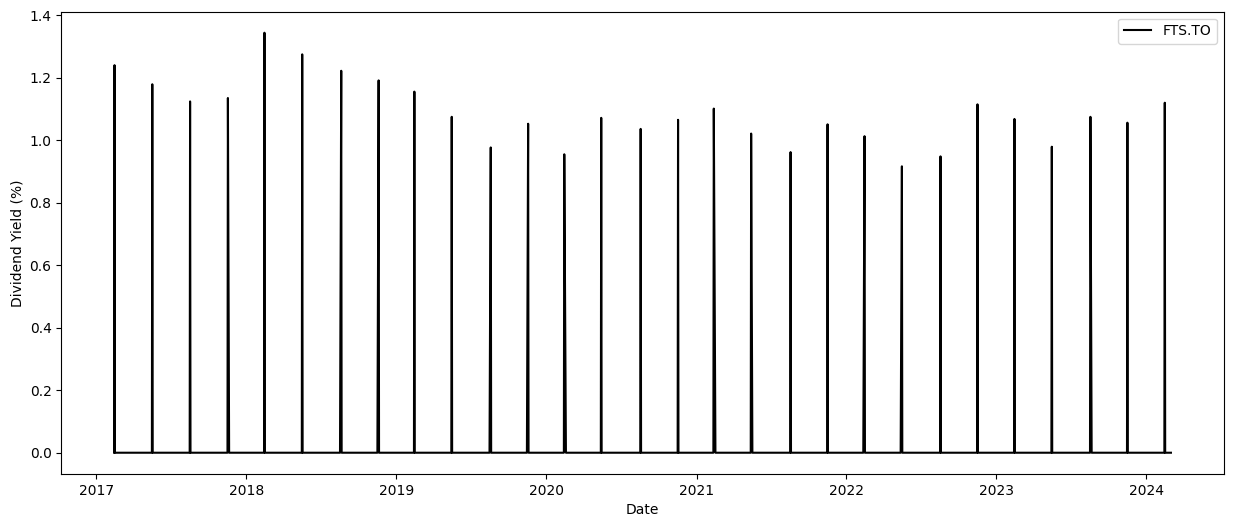

In [15]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.078002
share_price      1.000000
Name: share_price, dtype: float64


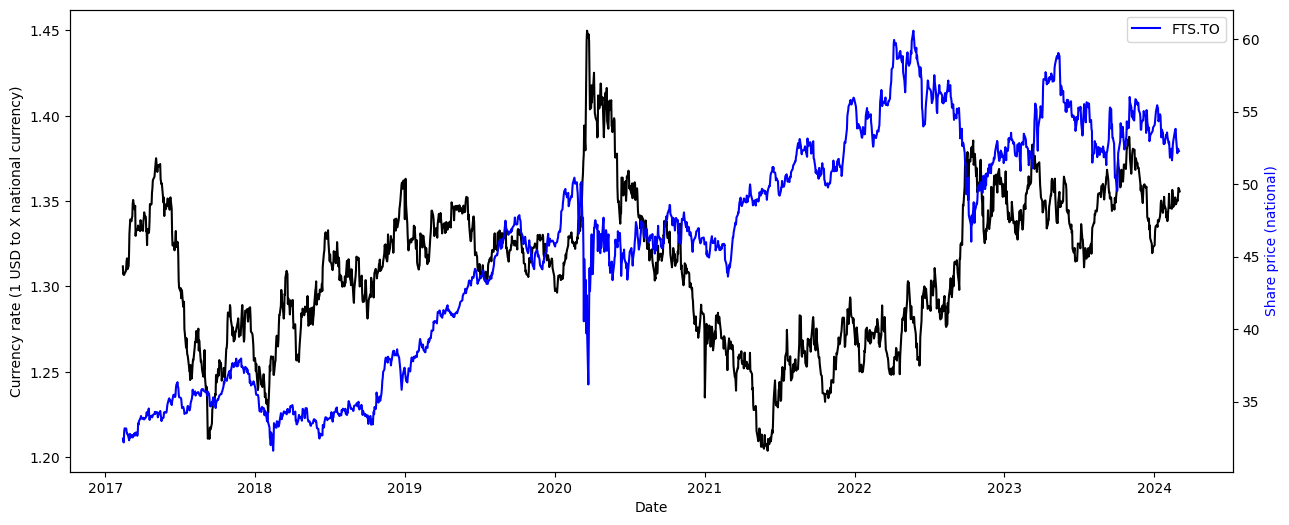

In [16]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

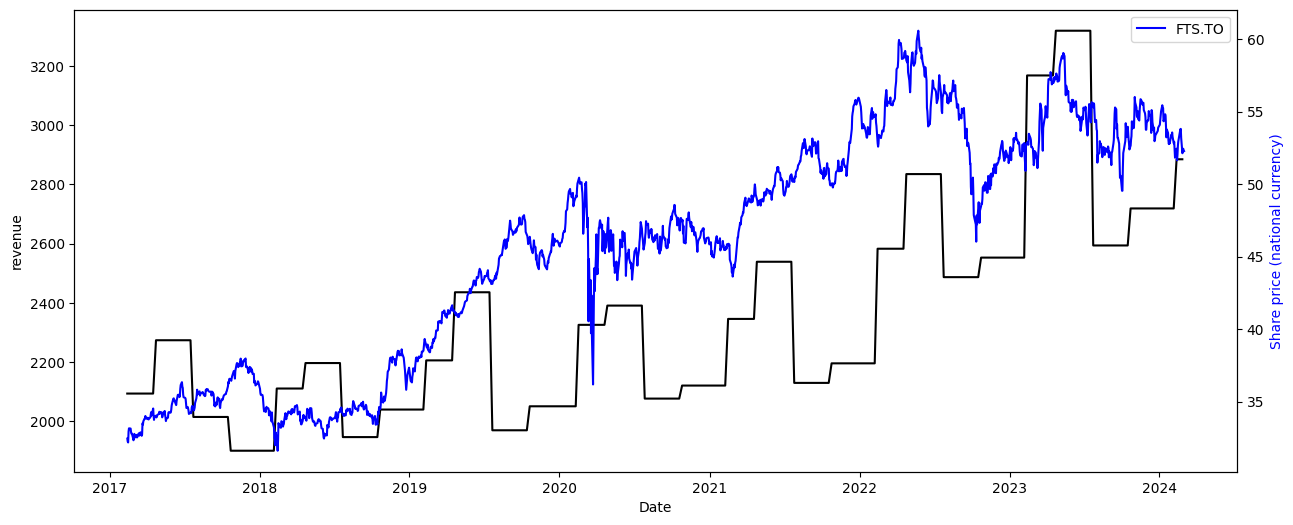

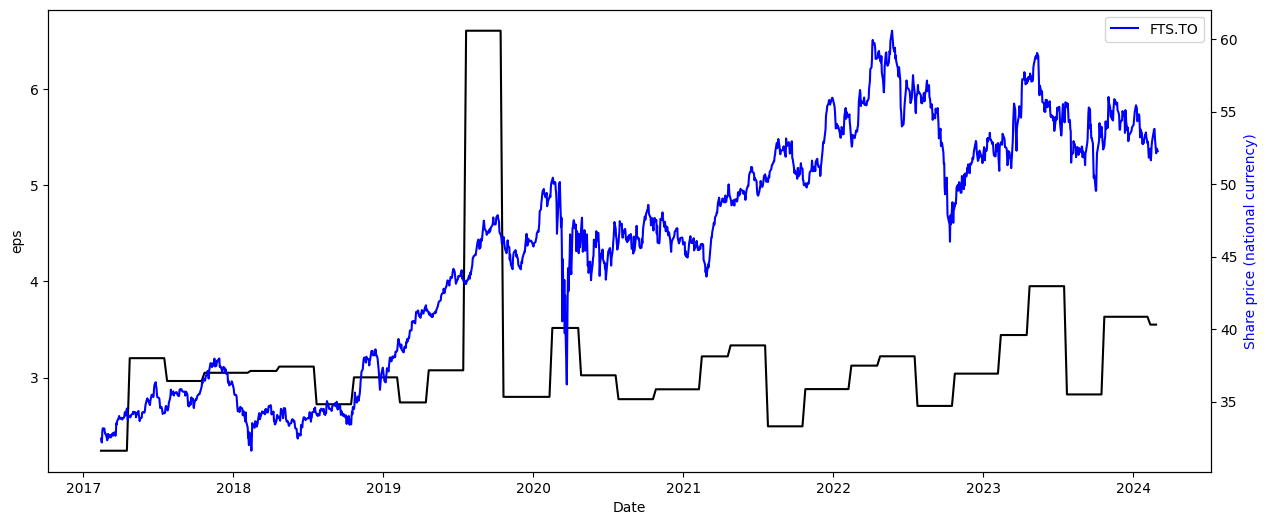

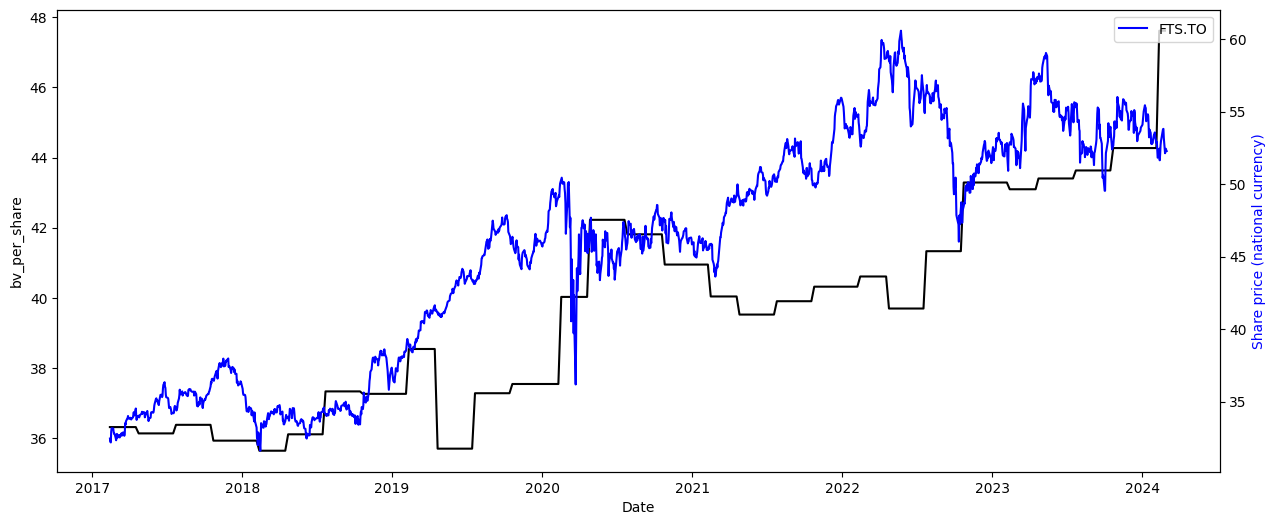

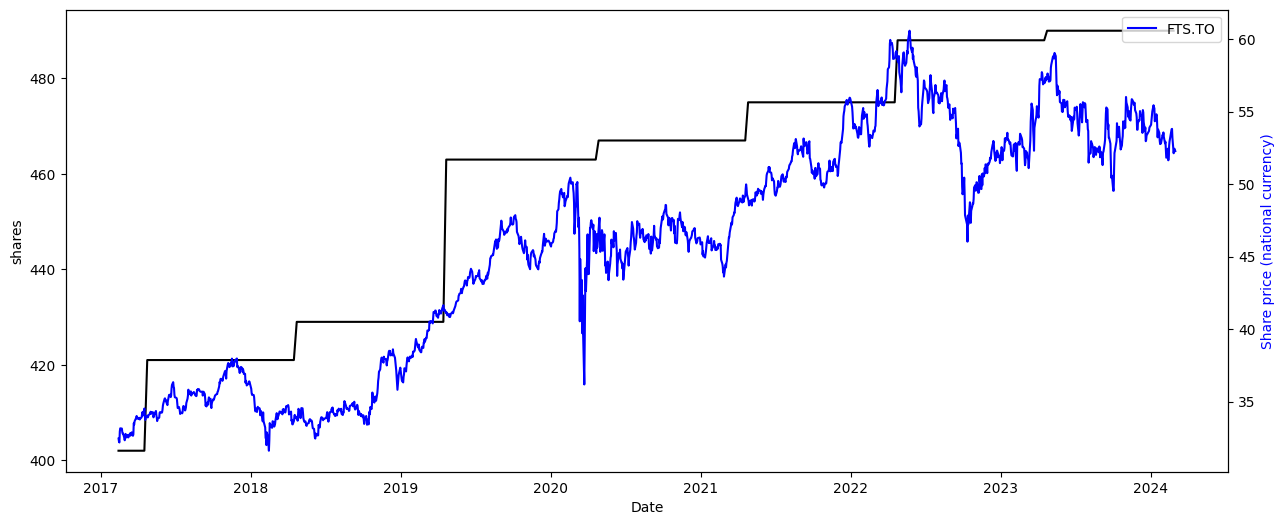

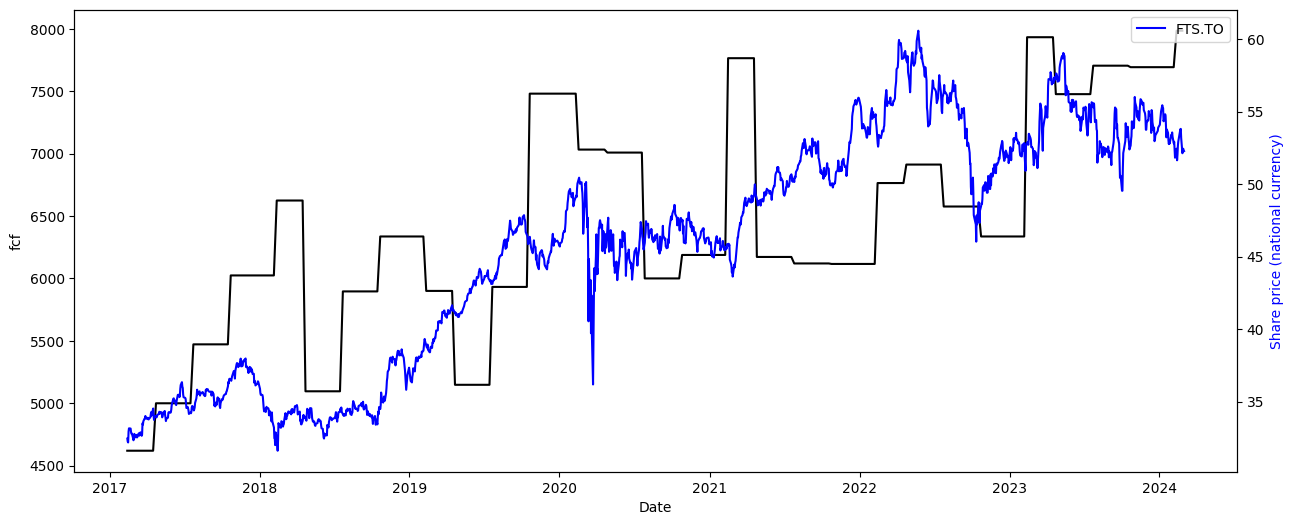

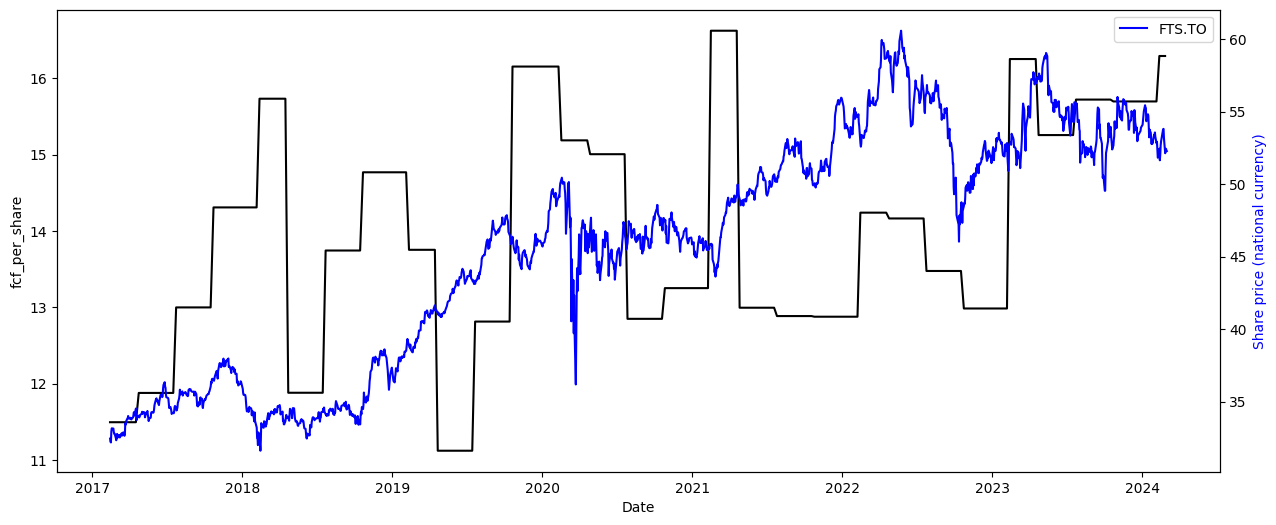

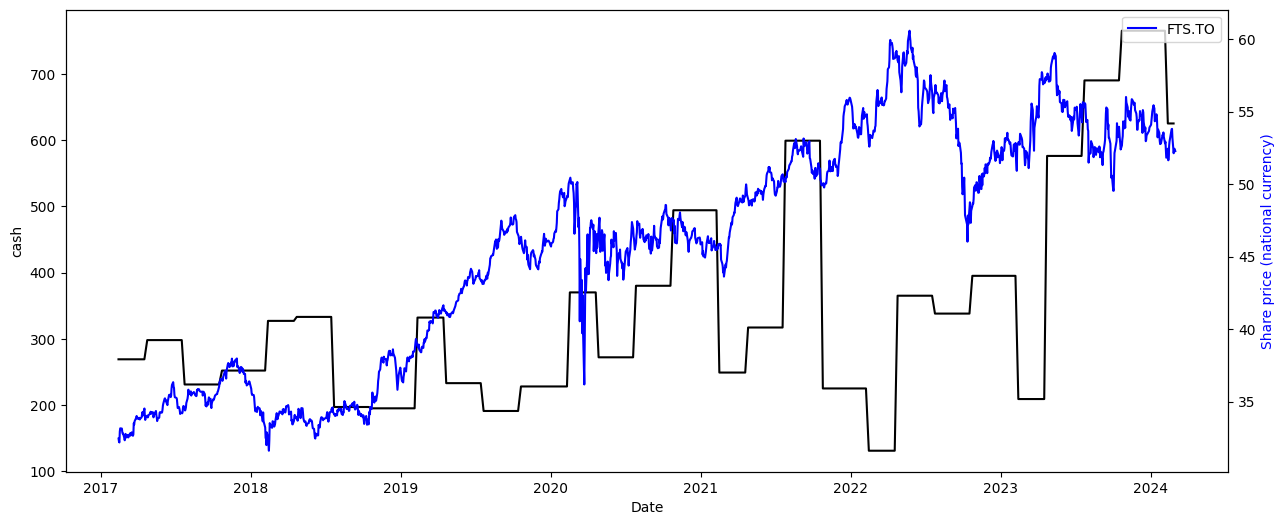

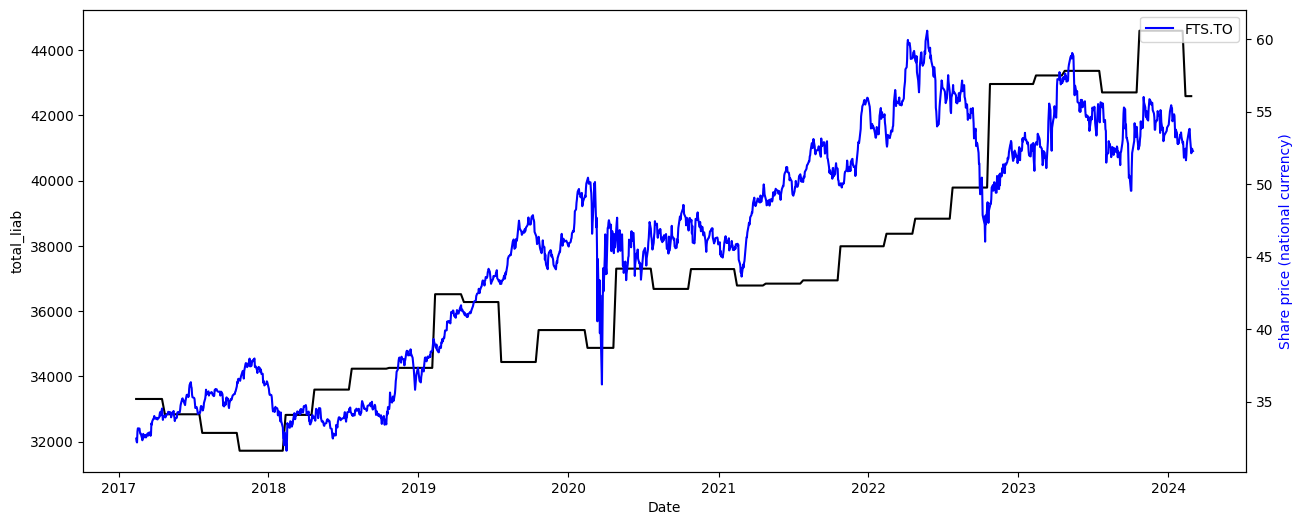

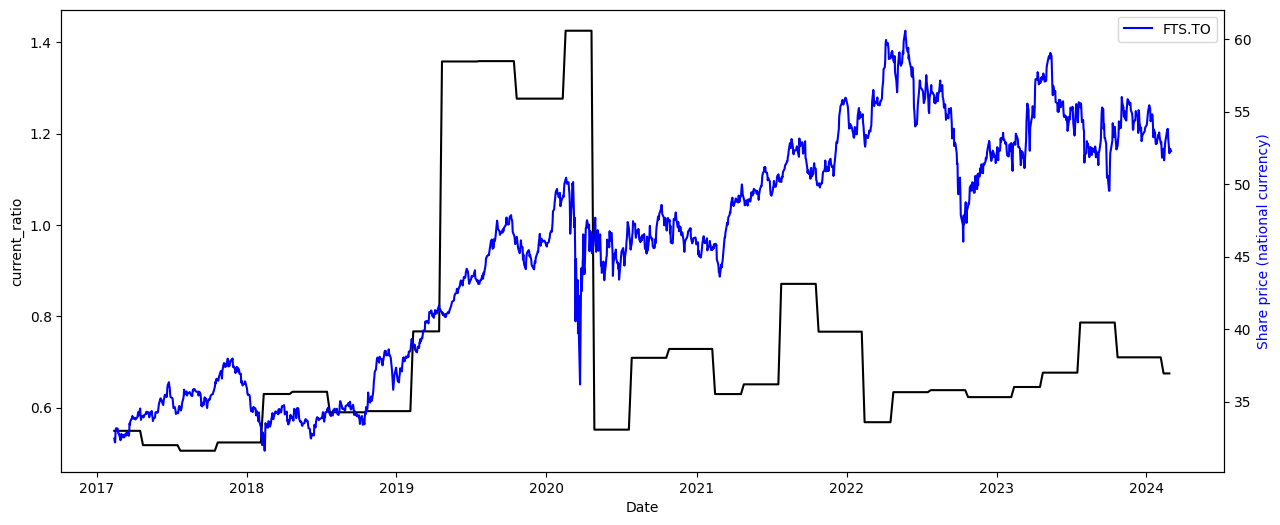

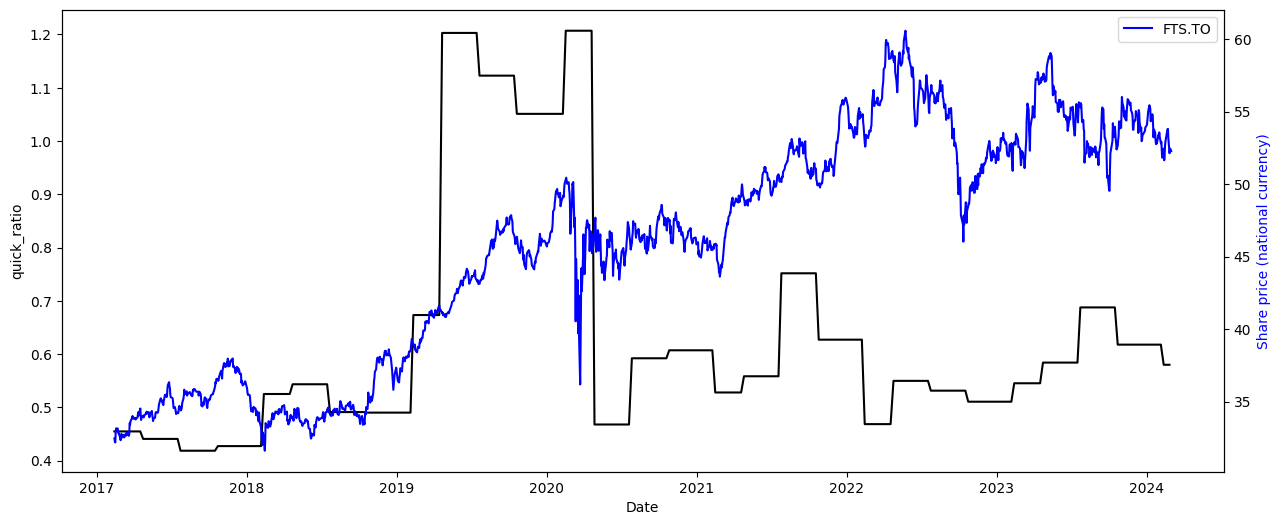

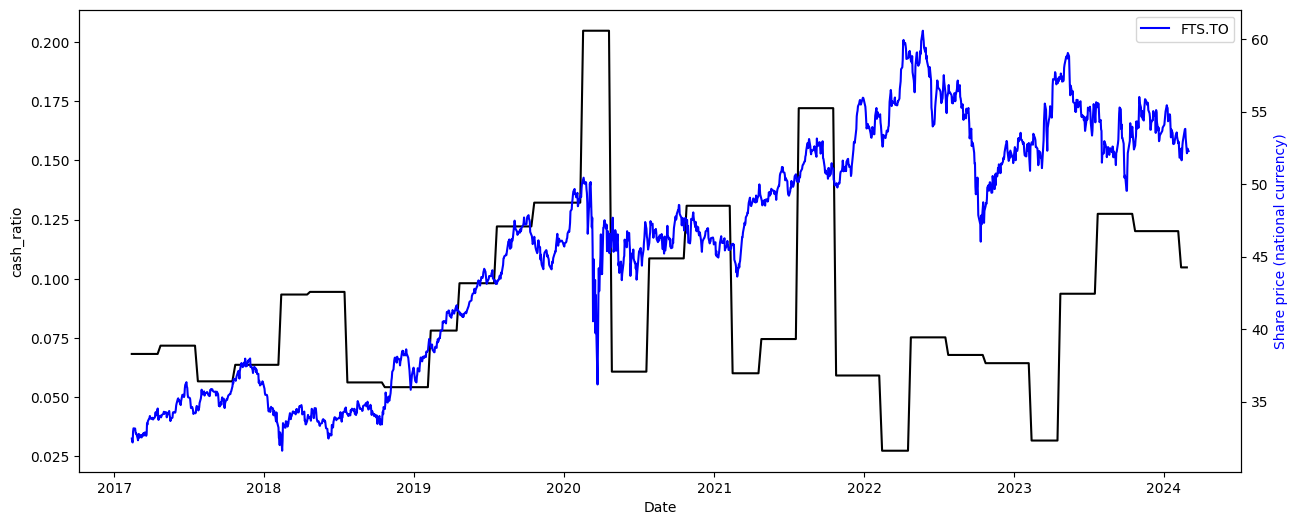

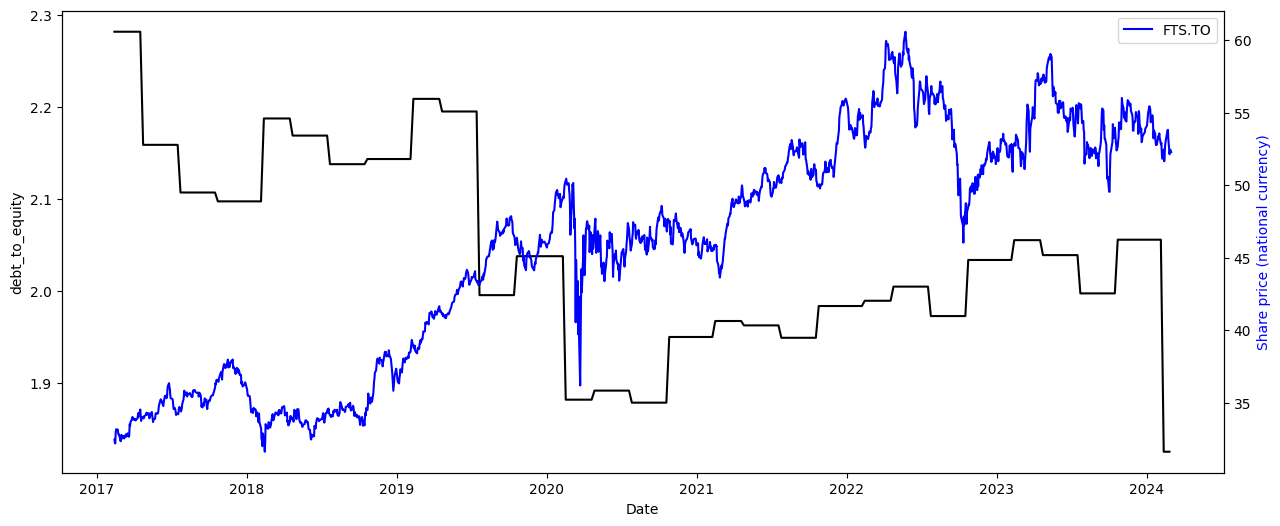

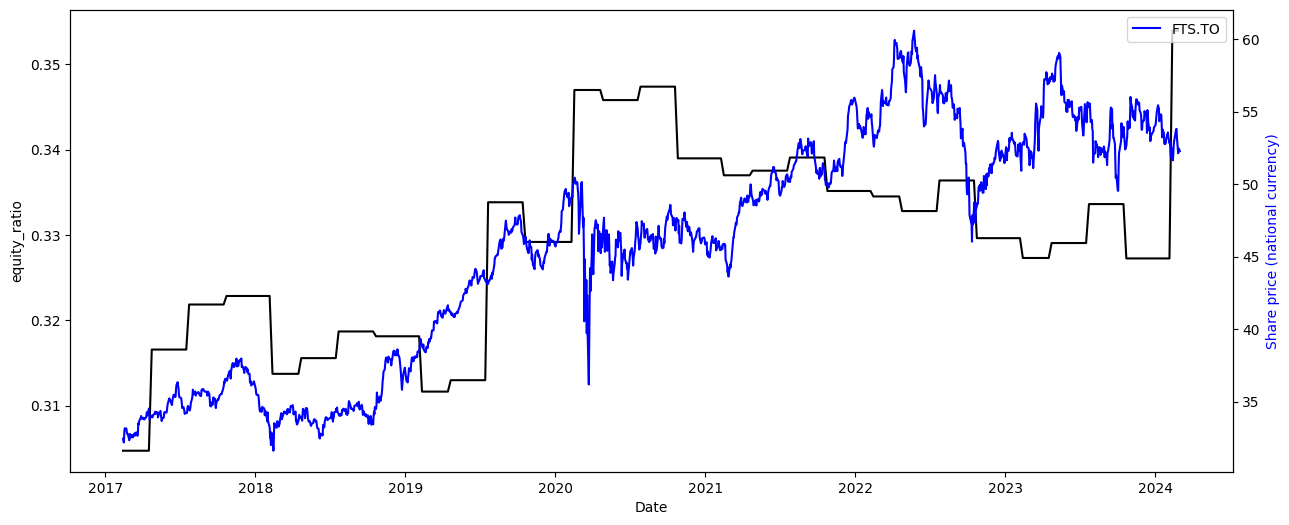

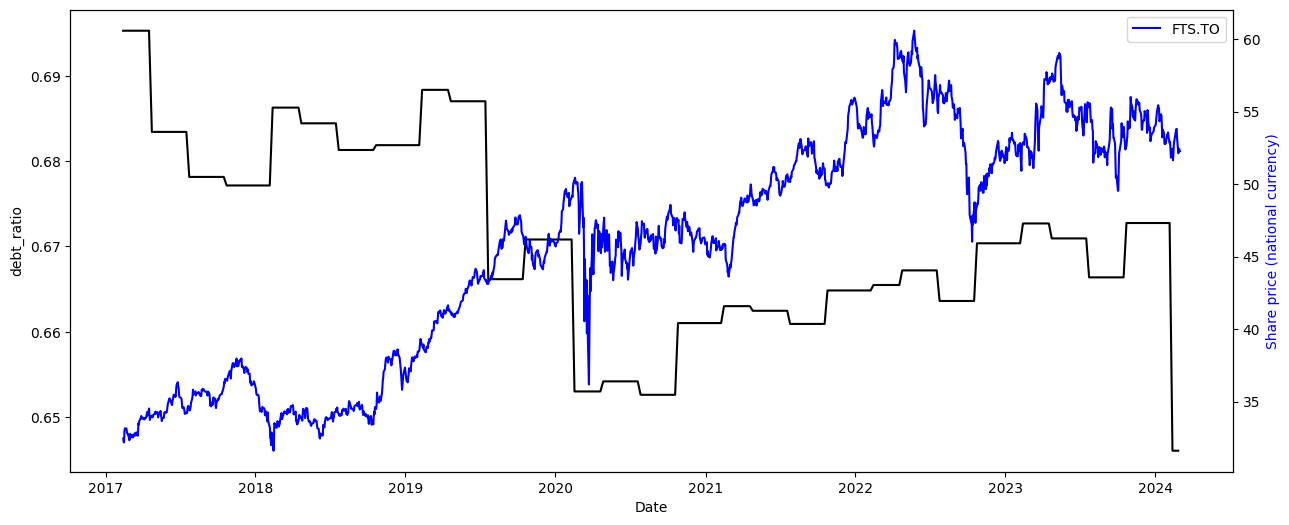

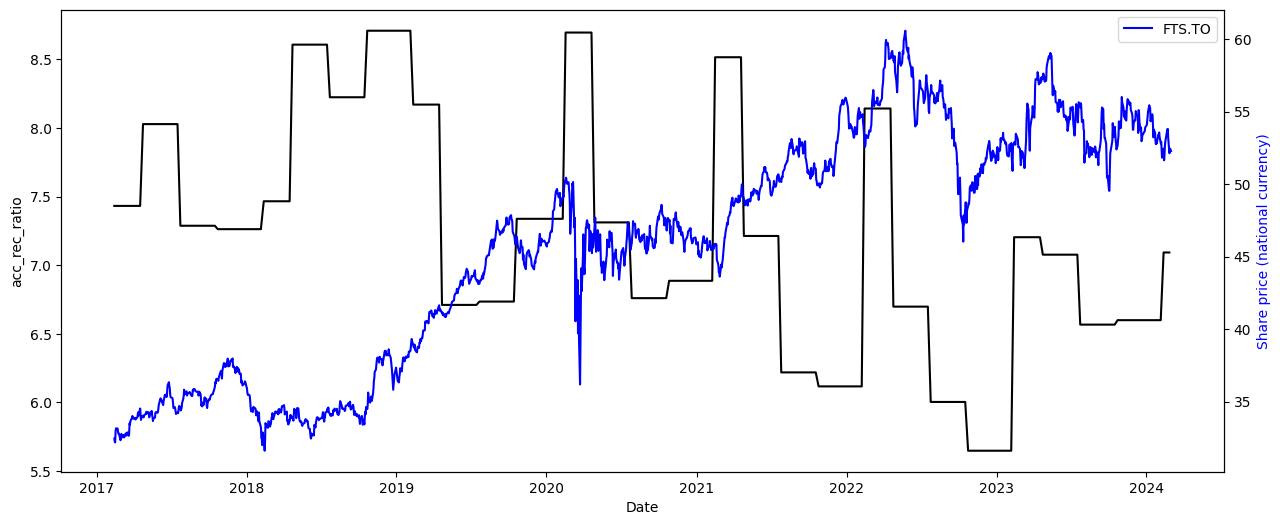

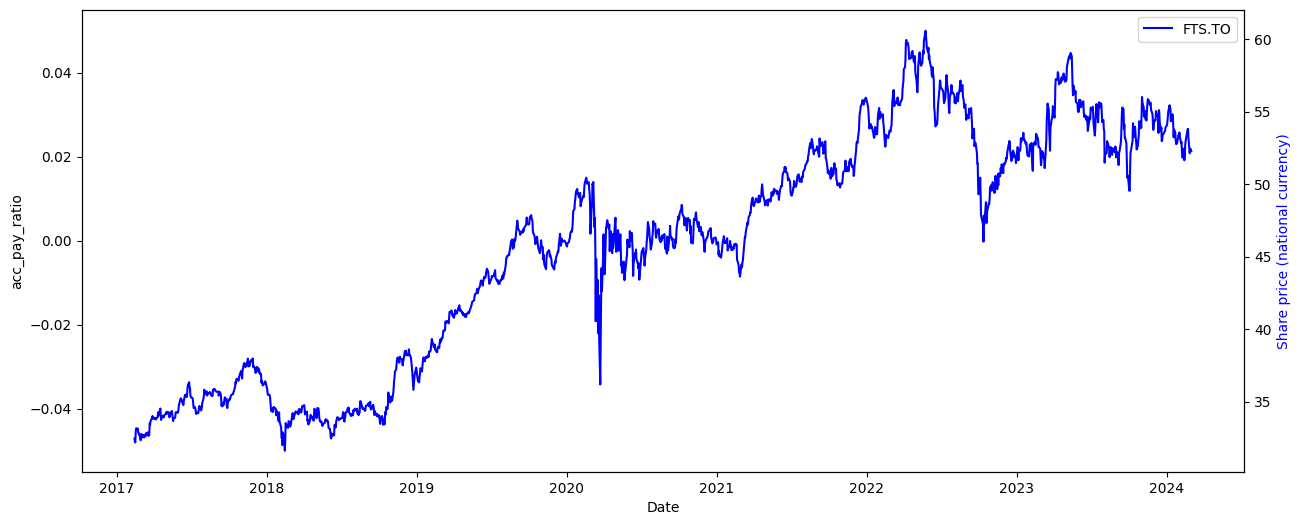

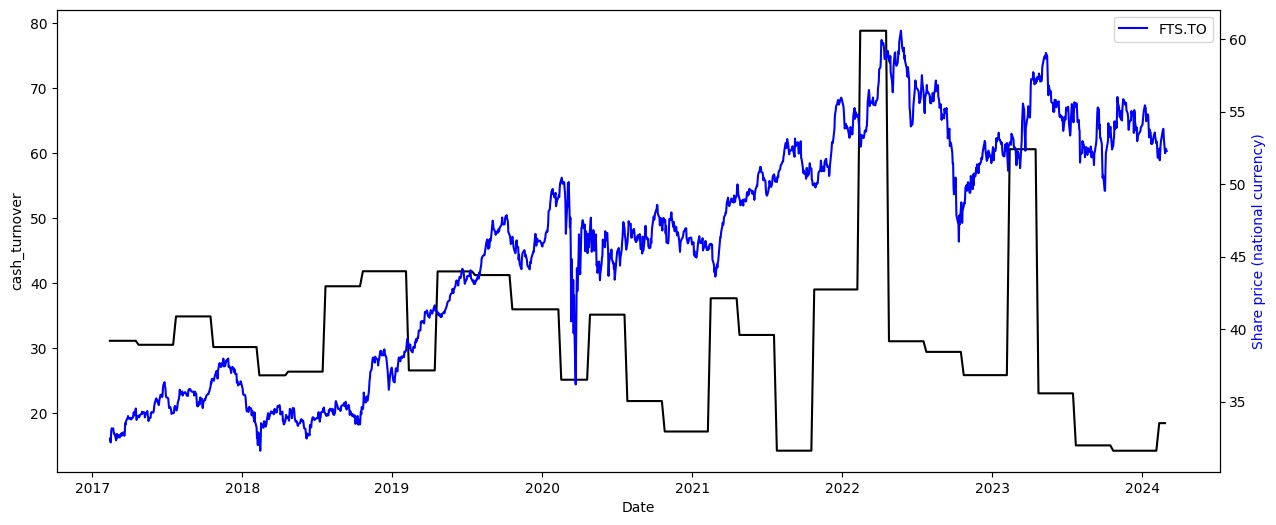

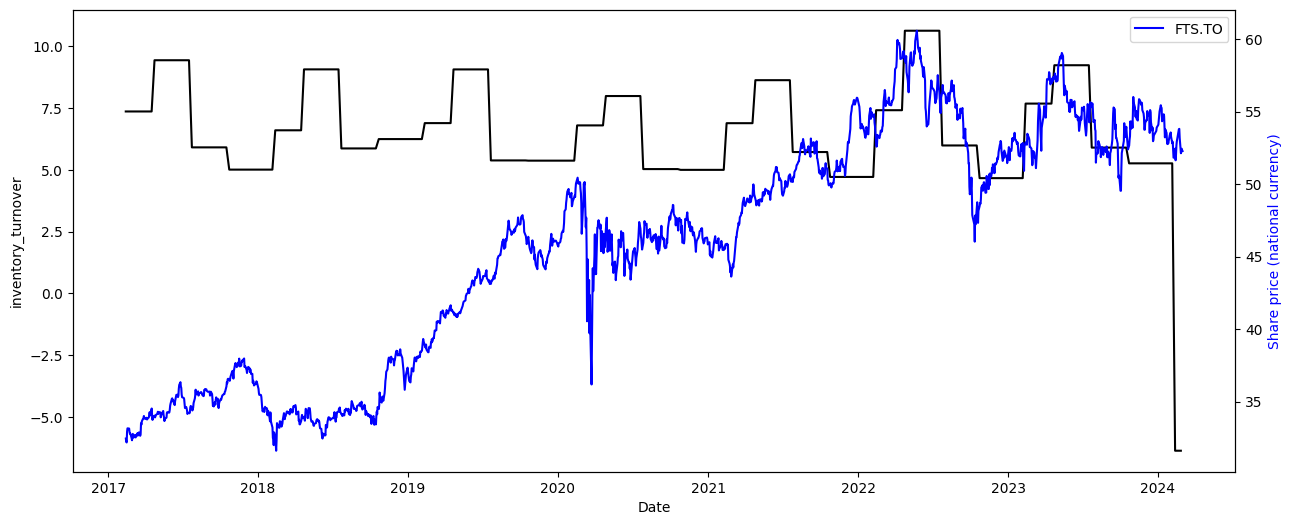

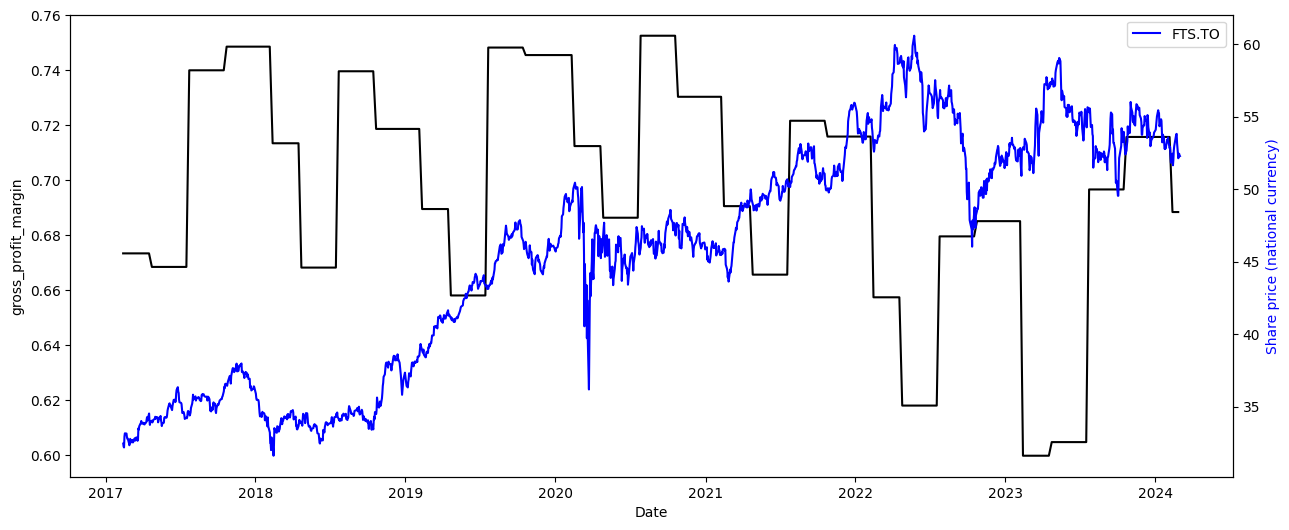

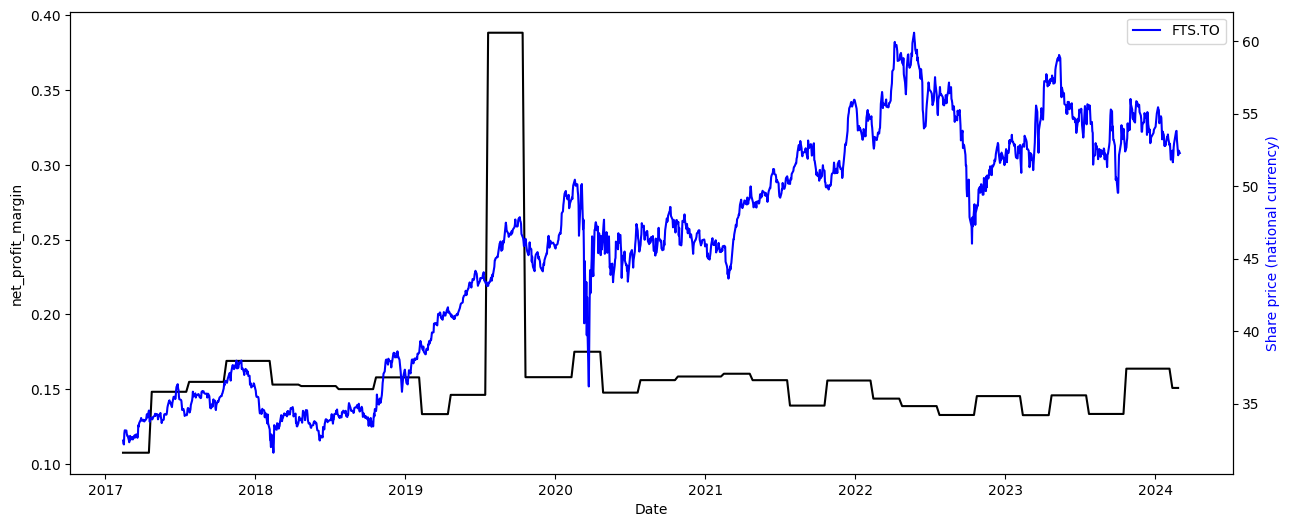

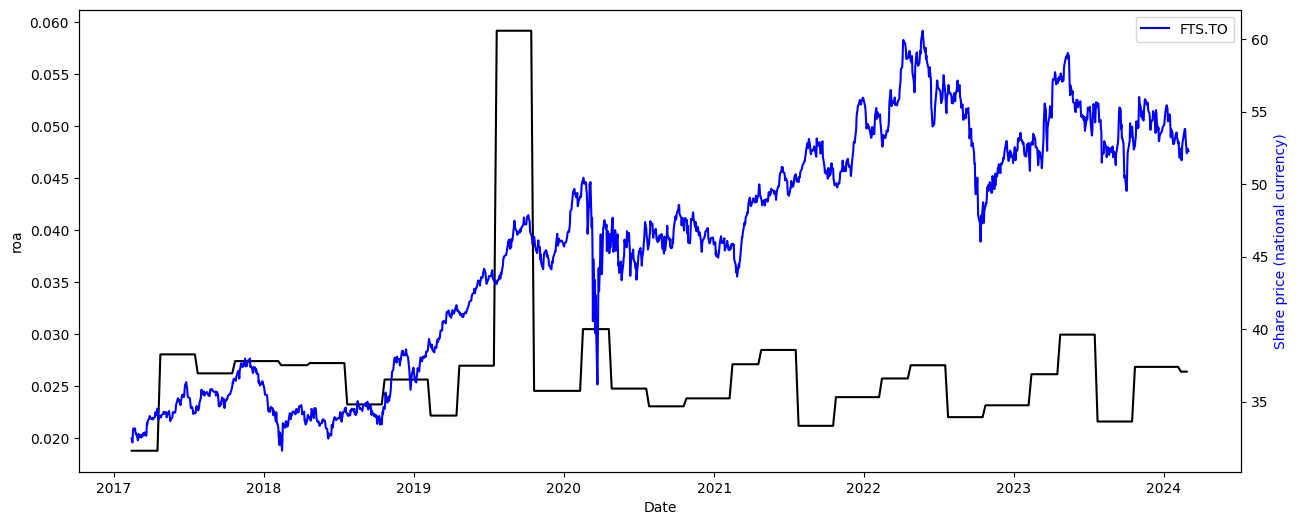

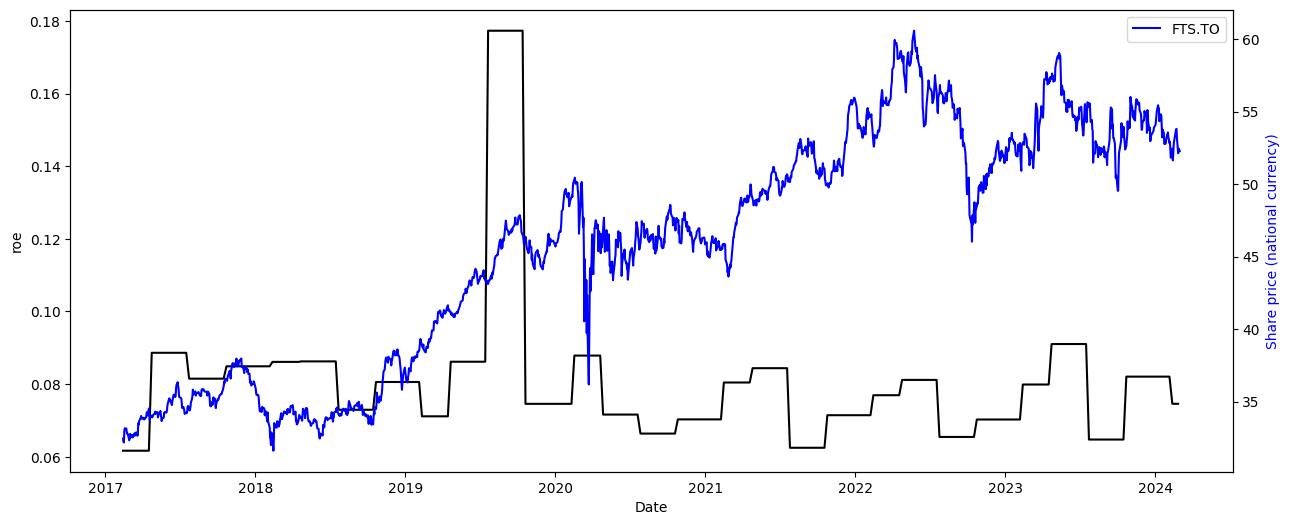

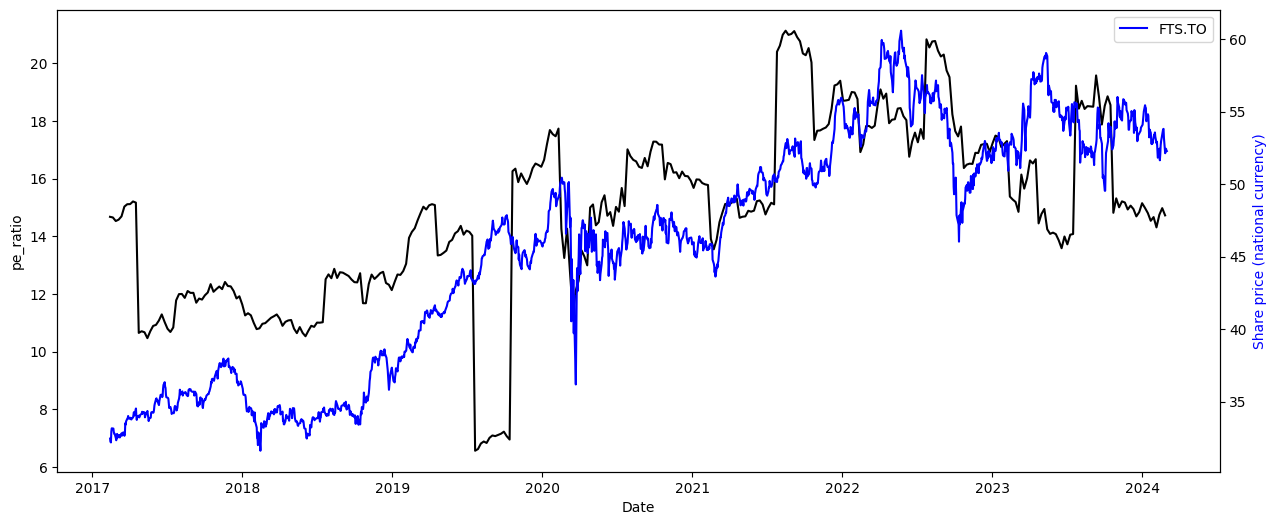

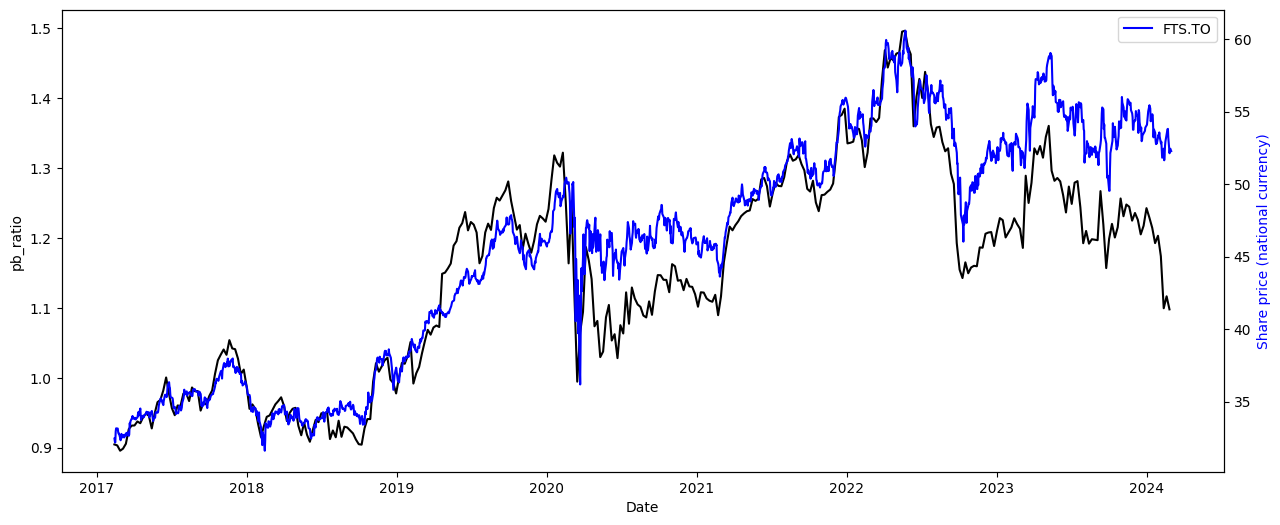

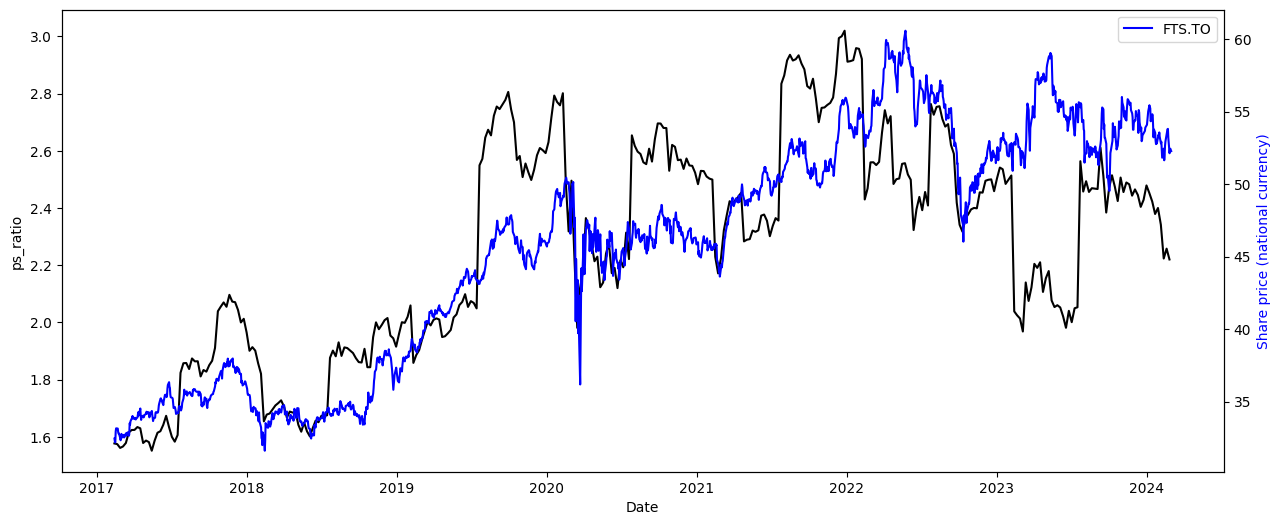

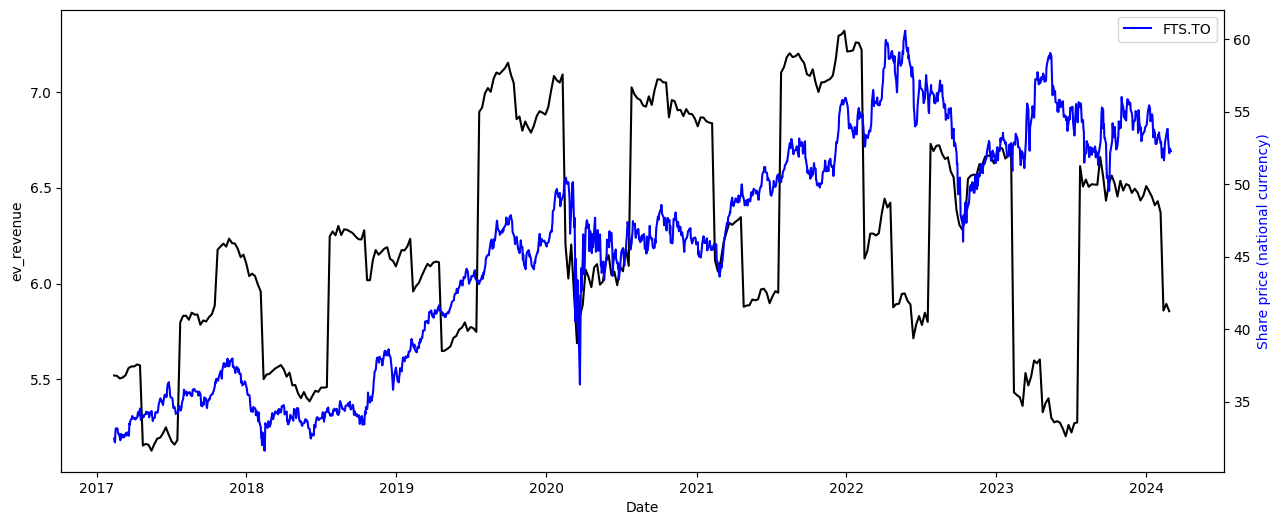

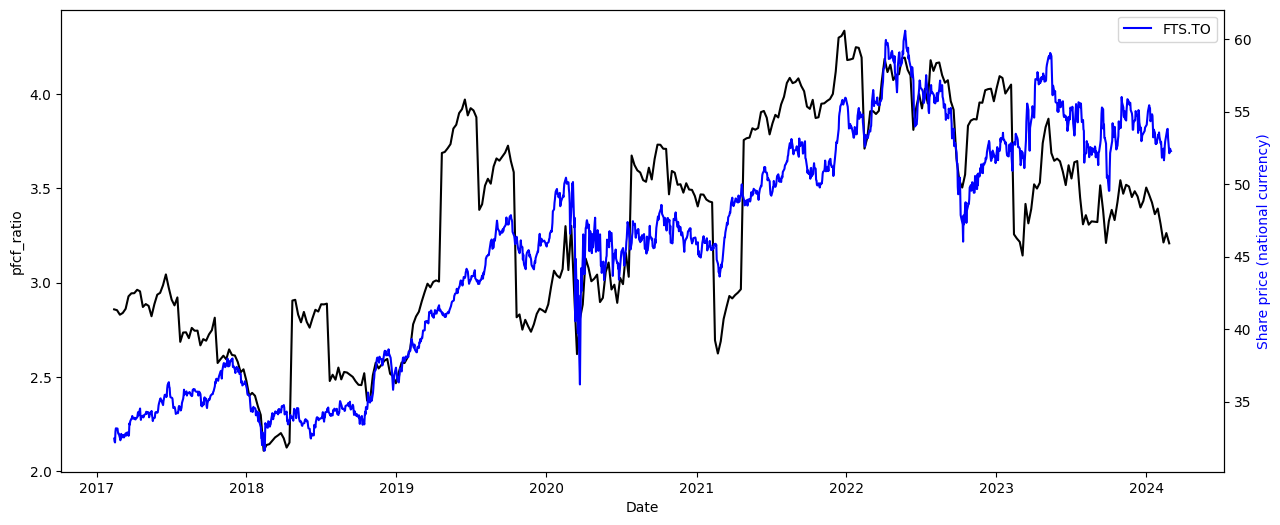

In [17]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

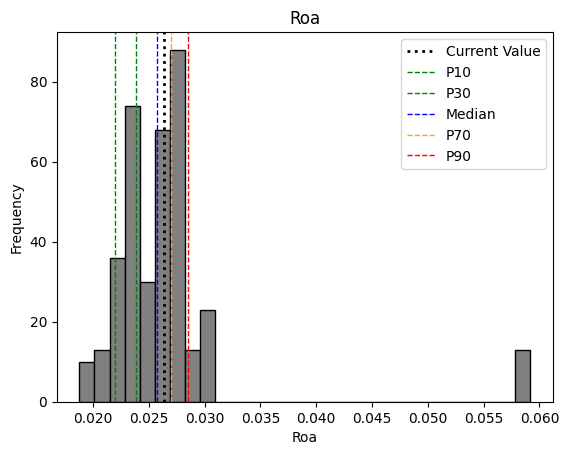

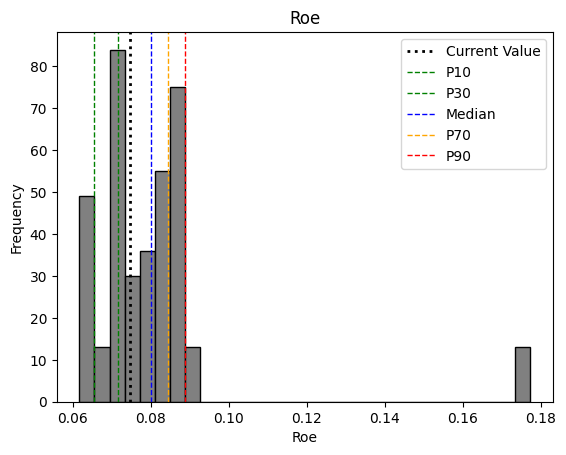

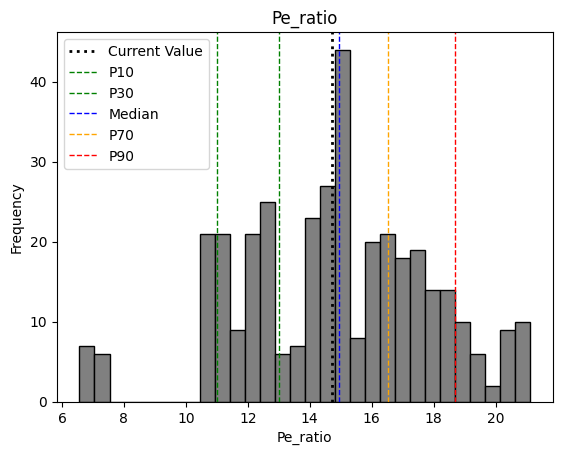

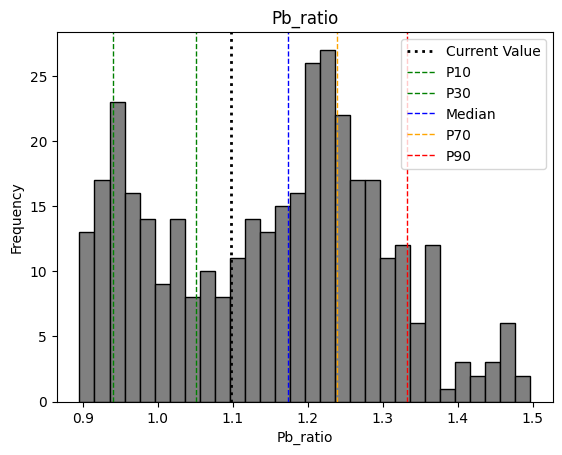

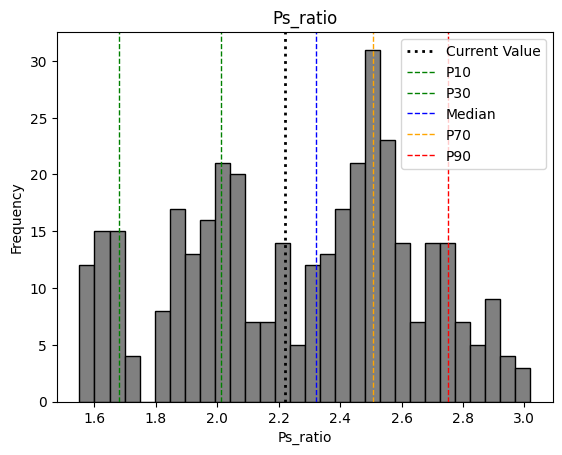

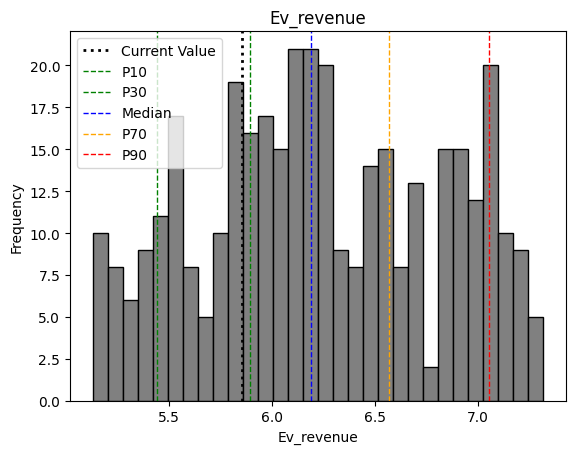

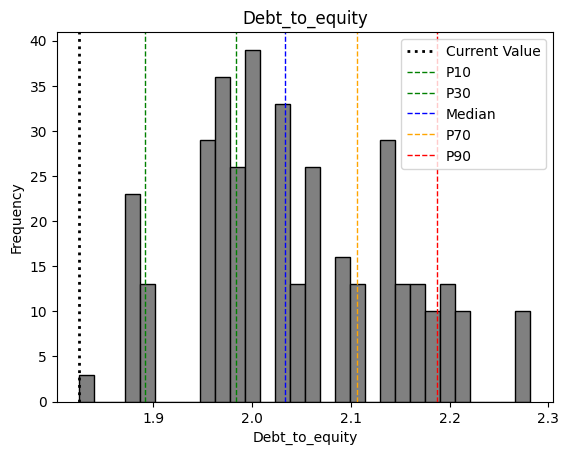

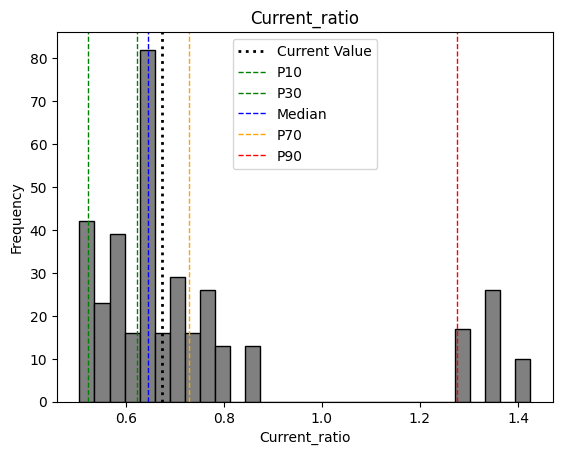

In [18]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[])

## Calculate correlation between value parameters

In [19]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.992310,-0.639804,0.112482,0.093022,0.048508,-0.090902,0.448404
roe,0.992310,1.000000,-0.697604,0.046829,0.001898,-0.018868,0.031712,0.428702
pe_ratio,-0.639804,-0.697604,1.000000,0.627293,0.639196,0.456168,-0.442048,-0.084025
pb_ratio,0.112482,0.046829,0.627293,1.000000,0.792988,0.405480,-0.542099,0.297349
ps_ratio,0.093022,0.001898,0.639196,0.792988,1.000000,0.862411,-0.739842,0.359104
ev_revenue,0.048508,-0.018868,0.456168,0.405480,0.862411,1.000000,-0.538238,0.325503
debt_to_equity,-0.090902,0.031712,-0.442048,-0.542099,-0.739842,-0.538238,1.000000,-0.154214
current_ratio,0.448404,0.428702,-0.084025,0.297349,0.359104,0.325503,-0.154214,1.000000


13 timestemos have been found!


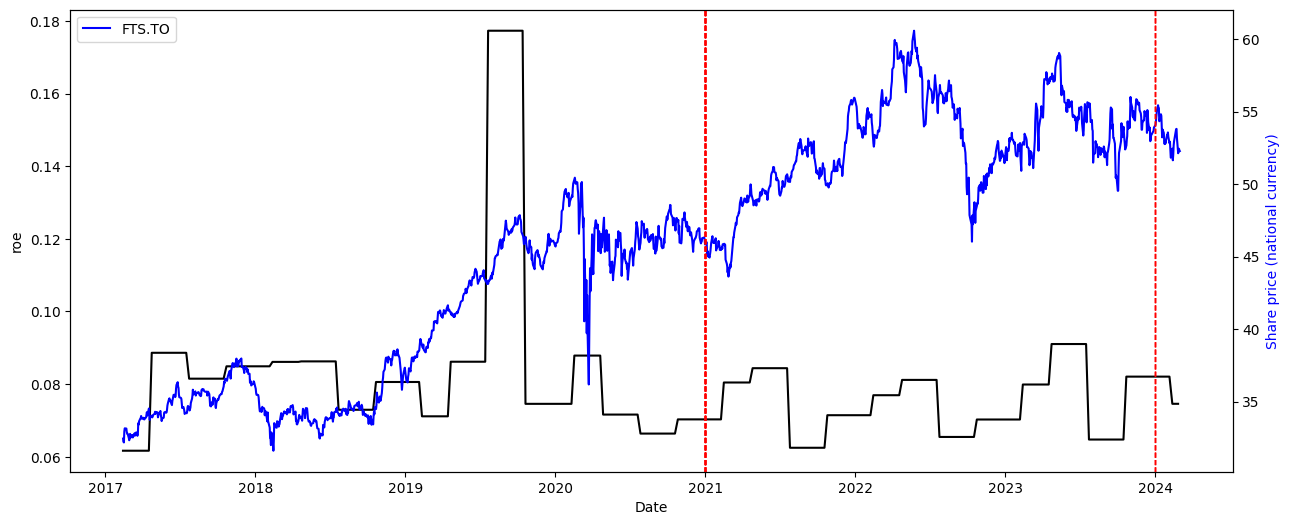

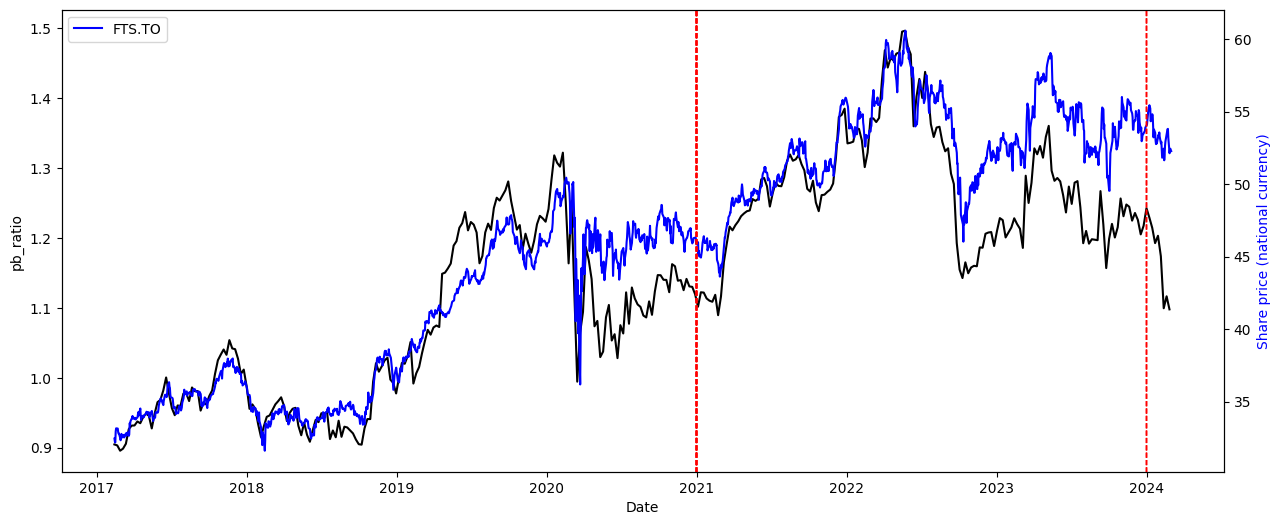

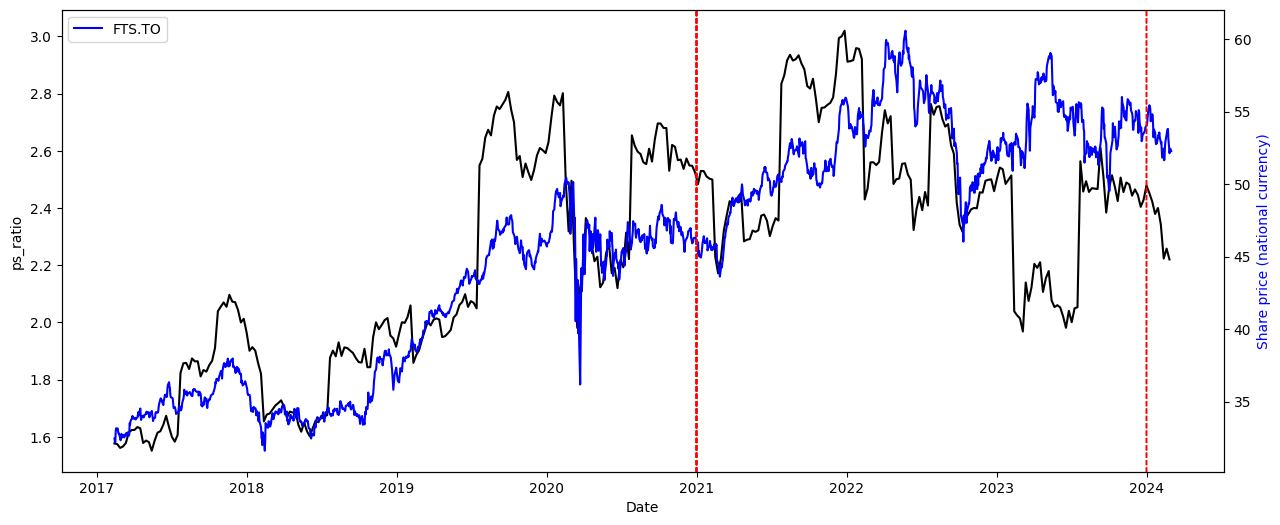

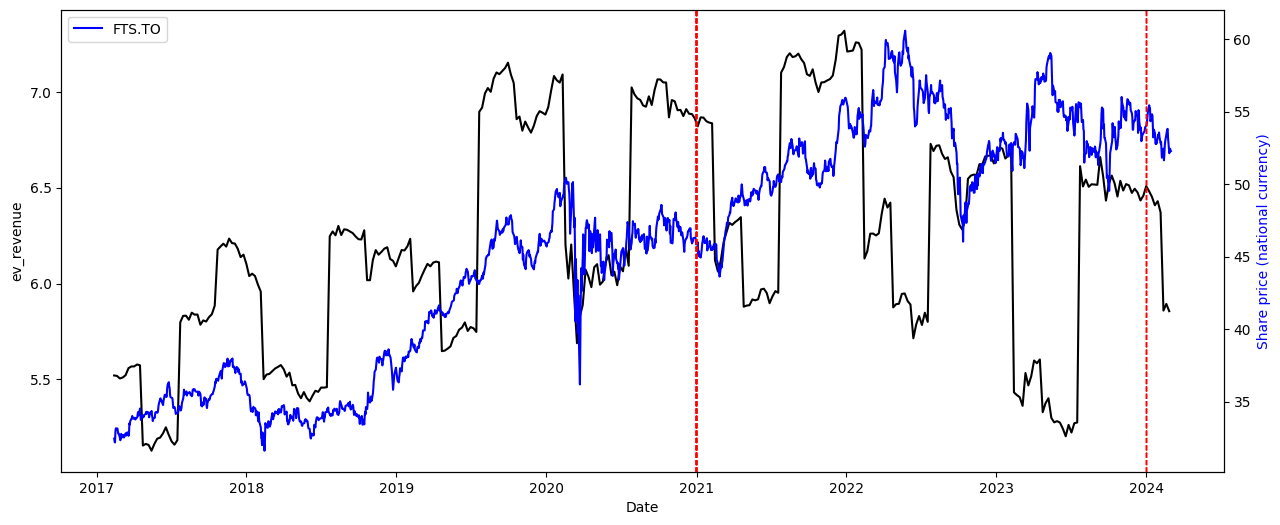

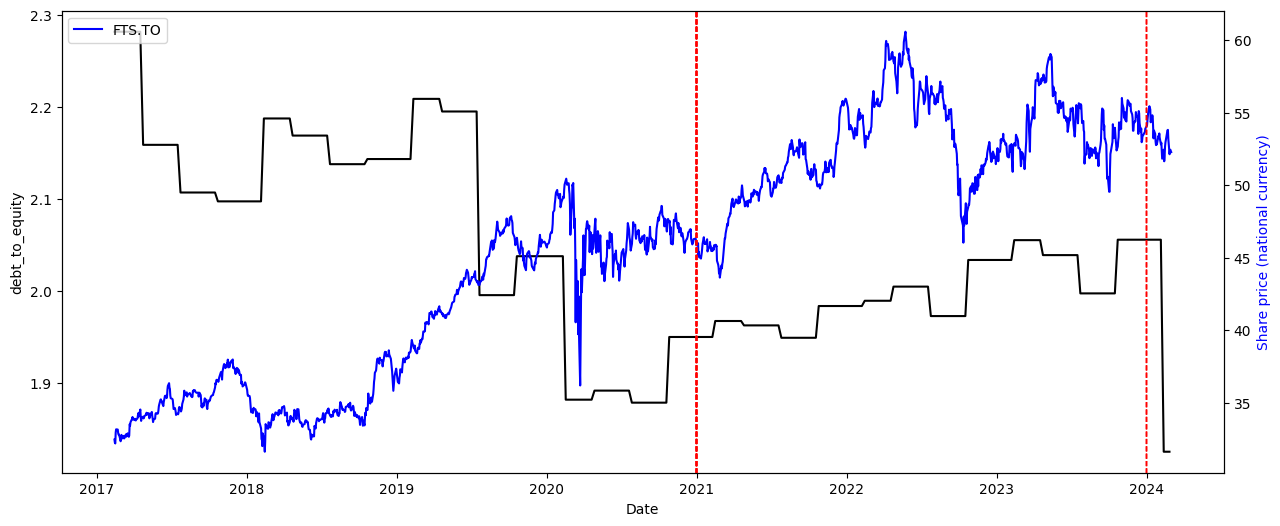

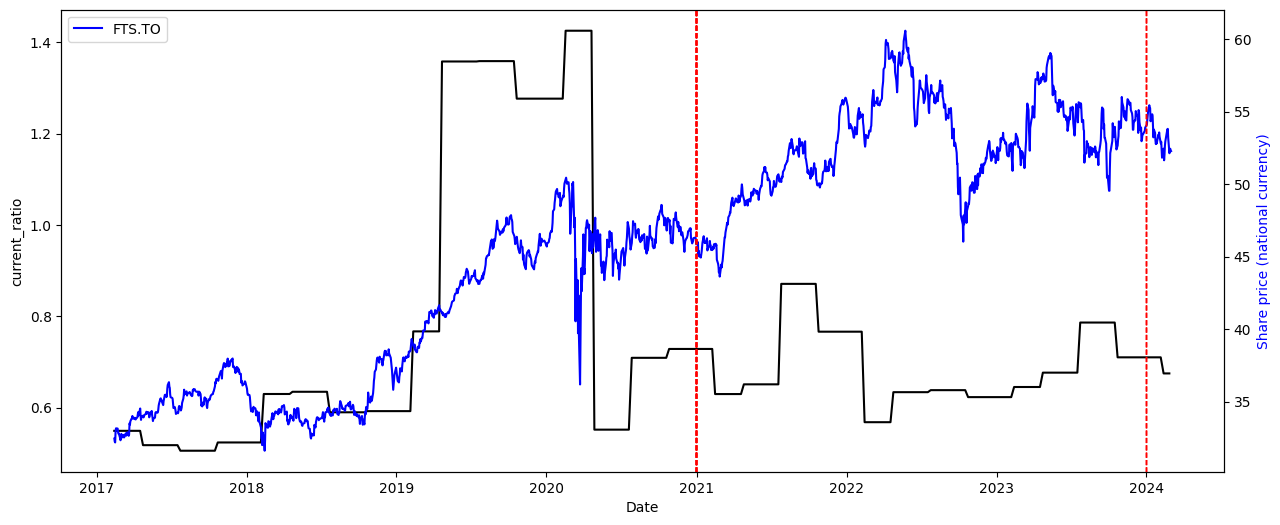

In [20]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.1
    )